**Подготовка рабочего пространства**

In [1]:
# !pip install -U scikit-learn

In [2]:
# !pip install phik

In [ ]:
from IPython.display import display, HTML 
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
warnings.filterwarnings('ignore') # чтобы не было красный полей с предупреждениями об устаревших библиотеках
%matplotlib inline
plt.ion() # принудительное отображение графиков matplotlib в VS Code
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:,.2f}'.format) # чтобы числа в датафрейме отображались с разрядностью
pd.set_option('display.float_format', '{:.2f}'.format) # округление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша

# **Описание проекта**

Компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. 

* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 

Представлено три датасета с данными по каждому региону.



## **Задача**
1) Построить модель для определения региона, где добыча принесёт наибольшую прибыль. 
2) Проанализировать возможную прибыль и риски техникой Bootstrap.

# **1. Загрузка и подготовка данных.**

In [5]:
try:
    geo_data_0_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/geo_data_0.csv')
    geo_data_1_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/geo_data_1.csv')
    geo_data_2_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/geo_data_2.csv')
except:
    geo_data_0_df = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1_df = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2_df = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [6]:
df_dict = {
            'geo_data_0_df': geo_data_0_df, 
            'geo_data_1_df': geo_data_1_df, 
            'geo_data_2_df': geo_data_2_df
            }

### **1.1. Описание данных**

**Данные геологоразведки трёх регионов содержат признаки:**
* **id** — уникальный идентификатор скважины;
* **f0**, **f1**, **f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
* **product** — объём запасов в скважине (тыс. баррелей).

### **1.2. Изучим данные**

Изучим данные и сделаем выводы. При необходимости выполним предобработку.

In [7]:
for name, df in df_dict.items():
    print(f'======={name}==========================')
    print(f'Данные {name} имеют следующие признаки:\n')
    display(df.head(10))
    df.info()

=======geo_data_0_df==========================
Данные geo_data_0_df имеют следующие признаки:



,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04
5,wX4Hy,0.97,0.49,-0.74,64.74
6,tL6pL,0.65,0.53,1.78,49.06
7,BYPU6,-0.40,0.81,-5.62,72.94
8,j9Oui,0.64,-0.55,2.37,113.36
9,OLuZU,2.17,0.56,9.44,127.91


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
=======geo_data_1_df==========================
Данные geo_data_1_df имеют следующие признаки:



,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77
5,HHckp,-3.33,-2.21,3.00,84.04
6,h5Ujo,-11.14,-10.13,4.00,110.99
7,muH9x,4.23,-0.00,2.00,53.91
8,YiRkx,13.36,-0.33,5.00,134.77
9,jG6Gi,1.07,-11.03,5.00,137.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
=======geo_data_2_df==========================
Данные geo_data_2_df имеют следующие признаки:



,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60
5,LzZXx,-0.76,0.71,2.59,90.22
6,WBHRv,-0.57,0.32,1.77,45.64
7,XO8fn,-1.91,-2.46,-0.18,72.48
8,ybmQ5,1.78,-0.28,3.00,106.62
9,OilcN,-1.21,-0.44,5.92,52.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### **1.3. EDA: Создание пайплайна для предобработки**

In [8]:
class DecimalPointChanger(BaseEstimator, TransformerMixin):
    """Класс для замены разделителя дроби в строковых столбцах"""

    def __init__(self, columns=None):
        """Инициализация заменщика дроби в строковых столбцах"""
        self.columns = columns  # список столбцов, в которых нужно заменить разделитель дроби
    
    def fit_transform(self, df, y=None):
        """Непосредственно заменяет разделитель дроби запятую на точку"""
        print('- Определяю необходимость замены запятой на точку')
        
        # Если columns не указаны, обрабатываем все столбцы
        cols_to_process = self.columns if self.columns else df.columns
        
        for col in cols_to_process:
            if col in df.columns:
                # Проверяем, есть ли запятые в столбце
                if df[col].dtype == 'object' and df[col].str.contains(',').any():
                    df[col] = df[col].str.replace(',', '.').astype(float)
                    print(f'- Заменил запятую на точку в столбце {col}')
                    print(f'--- Значения в столбце {col}: {df[col].unique()}\n')
                else:
                    print(f'- В столбце {col} замена разделителя не требуется')
        
        print('- Обработка завершена\n')
        return df

In [9]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления выбросов из данных методом IQR только для train"""

    def __init__(self, columns=None, factor=1.5):
        """Инициализация удалителя выбросов. Есть возможность указать столбцы, в которых убирать выбросы. По умолчанию размер услов 1.5 квартиля"""
        self.columns = columns
        self.factor = factor
        self.bounds_dict = {}  # для хранения границ выбросов


    def fit_transform(self, df, name=None, y=None):
        """Обучает удалитель выбросов - описывает размер квантилей и границы усов. Удаляет выбросы"""

        if 'test' in name:
            print(f'- Удаление выбросов не проводится в тестовой выборке {name}, пропускаю шаг.')
            return df

        print('- Определяю границы выбросов методом IQR')
        
        df_transformed = df.copy()

        
        cols_to_process = self.columns if self.columns else df_transformed.select_dtypes(include=[np.number]).columns
        
        # Проверка на наличие выбросов
        outlier_cols = []
        for col in cols_to_process:
            if col in df_transformed.columns:
                Q1 = df_transformed[col].quantile(0.25)
                Q3 = df_transformed[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.factor * IQR
                upper_bound = Q3 + self.factor * IQR
                self.bounds_dict[col] = (lower_bound, upper_bound)
                
                outliers = (df_transformed[col] < lower_bound) | (df_transformed[col] > upper_bound)
                if outliers.any():
                    outlier_cols.append(col)
        
        if not outlier_cols:
            print('- Выбросы не обнаружены')
            return df_transformed
        
        print(f'- Обнаружены выбросы в столбцах: {outlier_cols}')
        
        # Показ боксплотов для столбцов с выбросами
        n_cols = len(outlier_cols)
        fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))
        if n_cols == 1:
            axes = [axes]
        
        for i, col in enumerate(outlier_cols):
            lower_bound, upper_bound = self.bounds_dict[col]
            print(f'Нормальные пределы для {col}: [{lower_bound:.2f} - {upper_bound:.2f}]')
            sns.boxplot(y=df_transformed[col], ax=axes[i])
            axes[i].set_title(f'Выбросы в {col}')
        
        plt.tight_layout()
        plt.show()
        
        # Удаление выбросов
        print('- Выполняю удаление выбросов\n')
        for col, (lower_bound, upper_bound) in self.bounds_dict.items():
            if col in df_transformed.columns:
                outliers = (df_transformed[col] < lower_bound) | (df_transformed[col] > upper_bound)
                df_transformed = df_transformed[~outliers]
                
        return df_transformed

In [10]:
class ImplicitDuplicatesViewer(BaseEstimator, TransformerMixin):
    """Выводит уникальные значения каждого столбца для визуального определения неявных дубликатов"""

    def __init__(self, strategy='first', columns=None):
        """Инициализация определеителя неявных дуликатов"""
        self.columns = columns
        self.strategy = 'first'


    def fit(self, df, y=None):
        return self


    def transform(self, df, y=None):
        """Выводит уникальные значения каждого столбца для визуального определения неявных дуликатов"""

        print('- Выполняю поиск неявных дубликатов в нечисловых столбцах\n')

        if 'id' in df.columns:
            print(f'- Дубликаты по id: {df["id"].duplicated().sum()} дубликатов')
            print(f'- Уникальных id: {df["id"].nunique()} из {len(df)} записей')
        
        if self.strategy == 'first':
            print('- Выполняю удаление дубликатов по первому вхождению\n')
            df = df.drop_duplicates(subset=['id'], keep='first')


        if self.columns:
            for col in self.columns:
                if col in df.columns:
                    print(f'- Уникальные значения в столбце {col}: {df[col].unique()}\n')
            return df
        else: 
            columns = df.select_dtypes(exclude=[np.number]).columns
            for col in columns:
                print(f'- Уникальные значения в столбце {col}: {df[col].unique()}\n')
            return df
        

        
    def fit_transform(self, df, y=None):
        return self.fit(df, y).transform(df)

In [11]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления дубликатов"""

    def __init__(self, columns=None):
        """Инициализация удалителя дубликатов"""
        self.columns = columns

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        """Удаляет дубликаты"""

        duplicate_count = df.duplicated().sum()

        if duplicate_count:
            print(f'- Выявлено {duplicate_count} дубликатов')
            print('- Выполняю удаление дубликатов\n')

            if self.columns:
                df = df.drop_duplicates(subset=self.columns)                
            else:
                df = df.drop_duplicates()
            
            remaining_duplicates = df.duplicated().sum()
            print(f'- Осталось {remaining_duplicates} дубликатов\n')

        else:
            print('- Полных явных дубликатов не выявлено\n')


        return df
            
    
    def fit_transform(self, df, y=None):
        return self.fit(df, y).transform(df)

In [12]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """Класс для обработки пропущенных значений в данных."""

    def __init__(self, strategy='mean', fill_value=None):
        """Инициализация обработчика пропущенных значений. По умолчанию заполняет средним значением.
        """
        self.strategy = strategy
        self.fill_value = fill_value
        self.fill_values_ = {}  # для хранения значений для заполнения

    def fit_transform(self, df, y=None):
        """Заполняет пропущенные значения или удаляет строки в тестовой выборке. режимы: mean, median, mode, drop"""
        if self.strategy == 'mean':
            self.fill_values_ = df.select_dtypes(include=[np.number]).mean().to_dict() # словарь средних значений для каждого числового столбца

        elif self.strategy == 'median':
            self.fill_values_ = df.select_dtypes(include=[np.number]).median().to_dict()

        elif self.strategy == 'mode':
            self.fill_values_ = {}
            for col in df.columns:
                self.fill_values_[col] = df[col].value_counts().index[0]

        elif self.strategy == 'drop':
            if df.isna().sum().sum() > 0 or df.eq(" ").any().any():
                print('- Нашел пропуски в данных\n')
                display(df[df.isna().any(axis=1)])
                display(df[df.eq(" ").any(axis=1)])
                print('- Выполняю удаление этих строк с пропущенными значениями\n')
                df = df.dropna()
                df = df[~df.eq(" ").any(axis=1)]  # удаляет пустые пробелы типа пропуск
                if df.isna().sum().sum() == 0:
                    print('- Пропусков не осталось.\n')
                else:
                    print(f'- {df.isna().sum().sum()} пропусков осталось.\n')
                return df
            else:
                print('- Пропусков не найдено\n')

        for col, fill_value in self.fill_values_.items():
             if col in df.columns:
                if df[col].isnull().sum() > 0:
                    print(f'- В колонке {col} {df[col].isnull().sum()} пропусков. Заполняю пропуски\n')
                    df[col] = df[col].fillna(fill_value)

        return df

In [13]:
class EDAPreprocessor:
    """
    Основной класс пайплайна для предобработки данных
    """

    def __init__(self):
        self.steps = []  # список шагов предобработки, которые будут выполняться в пайплайне
        self.fitted_transformers = {}  # для хранения обученных трансформеров (запоминает что-то и делает)
        

    def add_decimal_point_changer(self, columns=None, step_name='decimal_point_changer'):
        decimal_point_changer = DecimalPointChanger(columns)
        self.steps.append((step_name, decimal_point_changer))
        return self


    def add_missing_value_handler(self, strategy='drop', fill_value=None, step_name='missing_handler'):
        """Добавляет обработчик пропущенных значений в препроцессор"""
        handler = MissingValueHandler(strategy=strategy, fill_value=fill_value)
        self.steps.append((step_name, handler))
        return self    


    def add_outlier_remover(self, step_name='outlier_remover'):
        '''Добавляет шаг удаления выбросов в препроцессор только для train'''
        outlier_remover = OutlierRemover()
        self.steps.append((step_name, outlier_remover))
        return self
 
    
    def add_drop_duplicates(self, step_name='drop_duplicates'):
        """Добавляет шаг удаления дуликатов"""
        duplicate_remover = DuplicateRemover()
        self.steps.append((step_name, duplicate_remover))
        return self
    

    def add_implicit_duplicates_viewer(self, strategy='first', step_name='implicit_duplicates_viewer'):
        """Добавляет шаг отображения уникальных значений каждого столбца для выявления неявных дуликатов визуально."""
        implict_duplicates_viewer = ImplicitDuplicatesViewer(strategy=strategy)
        self.steps.append((step_name, implict_duplicates_viewer))
        return self
    

    def add_custom_transformer(self, step_name: str, transformer):
        """Добавляет пользовательский трансформер в пайплан предобраотки"""
        self.steps.append((step_name, transformer))
        return self
    

    def fit_transform(self, df, name=None, y=None):
        """Обучает все трансформеры пайплайна (запоминает единые параметры и условия исполнения - консистентность). Принимает df и целевую переменную опционально."""

        for i, (step_name, transformer) in enumerate(self.steps):
            print(f'Исполнение шага {i+1}: {step_name}')
            df = transformer.fit_transform(df, name)
            self.fitted_transformers[step_name] = transformer
            # df = transformer.transform(df)
        return df

### **1.4. EDA: Предобработка данных**

Выявим и исправим замечания.

In [14]:
EDA_Preprocessor_pipeline = (
    EDAPreprocessor()  
    .add_decimal_point_changer()        # проверяет наличие запятой в дробном чисе если найдет заменит на точку
    .add_missing_value_handler()
    .add_drop_duplicates()              # проверяет строки дубликаты
    .add_implicit_duplicates_viewer()   # выводит уникальные значения для определения неявных дуликатов
    .add_outlier_remover()              # удаляет пропуски, тестовую выборку пропустит
)

print('Вот такким у нас получился предобработчки данных.')

print("Шаги в пайплайне:")
for i, (name, step) in enumerate(EDA_Preprocessor_pipeline.steps):
    print(f"{i+1}. {name}: {step}\n")

Вот такким у нас получился предобработчки данных.
Шаги в пайплайне:
1. decimal_point_changer: DecimalPointChanger()

2. missing_handler: MissingValueHandler(strategy='drop')

3. drop_duplicates: DuplicateRemover()

4. implicit_duplicates_viewer: ImplicitDuplicatesViewer()

5. outlier_remover: OutlierRemover()



Исправим выявленные замечания.

 =>  Обработка датафрейма geo_data_0_df
Исполнение шага 1: decimal_point_changer
- Определяю необходимость замены запятой на точку
- В столбце id замена разделителя не требуется
- В столбце f0 замена разделителя не требуется
- В столбце f1 замена разделителя не требуется
- В столбце f2 замена разделителя не требуется
- В столбце product замена разделителя не требуется
- Обработка завершена

Исполнение шага 2: missing_handler
- Пропусков не найдено

Исполнение шага 3: drop_duplicates
- Полных явных дубликатов не выявлено

Исполнение шага 4: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Дубликаты по id: 10 дубликатов
- Уникальных id: 99990 из 100000 записей
- Выполняю удаление дубликатов по первому вхождению

- Уникальные значения в столбце id: ['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']

Исполнение шага 5: outlier_remover
- Определяю границы выбросов методом IQR
- Обнаружены выбросы в столбцах: ['f2']
Нормальные пределы для f2: [-6.35 

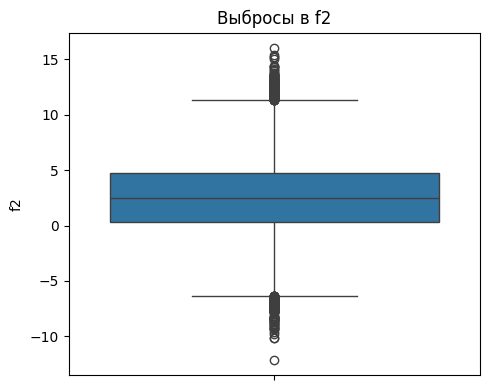

- Выполняю удаление выбросов


Проверка датафрейма geo_data_0_df


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


,f0,f1,f2,product
count,99484.00,99484.00,99484.00,99484.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.18,44.23
min,-1.41,-0.85,-6.35,0.00
25%,-0.07,-0.20,0.30,56.57
50%,0.50,0.25,2.52,91.84
75%,1.07,0.70,4.70,128.52
max,2.36,1.34,11.35,185.36


 =>  Обработка датафрейма geo_data_1_df
Исполнение шага 1: decimal_point_changer
- Определяю необходимость замены запятой на точку
- В столбце id замена разделителя не требуется
- В столбце f0 замена разделителя не требуется
- В столбце f1 замена разделителя не требуется
- В столбце f2 замена разделителя не требуется
- В столбце product замена разделителя не требуется
- Обработка завершена

Исполнение шага 2: missing_handler
- Пропусков не найдено

Исполнение шага 3: drop_duplicates
- Полных явных дубликатов не выявлено

Исполнение шага 4: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Дубликаты по id: 4 дубликатов
- Уникальных id: 99996 из 100000 записей
- Выполняю удаление дубликатов по первому вхождению

- Уникальные значения в столбце id: ['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']

Исполнение шага 5: outlier_remover
- Определяю границы выбросов методом IQR
- Обнаружены выбросы в столбцах: ['f0', 'f1']
Нормальные пределы для f0: [-

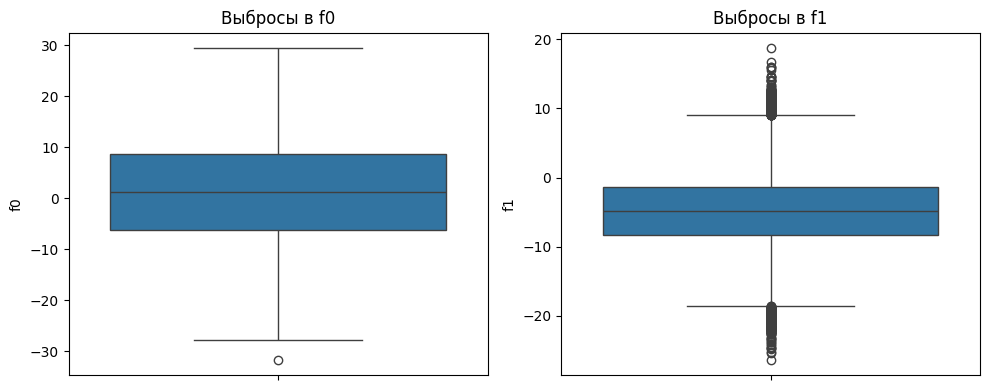

- Выполняю удаление выбросов


Проверка датафрейма geo_data_1_df


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


,f0,f1,f2,product
count,99359.00,99359.00,99359.00,99359.00
mean,1.14,-4.80,2.49,68.81
std,8.97,4.98,1.70,45.94
min,-27.83,-18.67,-0.02,0.00
25%,-6.30,-8.25,1.00,26.95
50%,1.15,-4.82,2.01,57.09
75%,8.62,-1.36,4.00,107.81
max,29.42,9.05,5.02,137.95


 =>  Обработка датафрейма geo_data_2_df
Исполнение шага 1: decimal_point_changer
- Определяю необходимость замены запятой на точку
- В столбце id замена разделителя не требуется
- В столбце f0 замена разделителя не требуется
- В столбце f1 замена разделителя не требуется
- В столбце f2 замена разделителя не требуется
- В столбце product замена разделителя не требуется
- Обработка завершена

Исполнение шага 2: missing_handler
- Пропусков не найдено

Исполнение шага 3: drop_duplicates
- Полных явных дубликатов не выявлено

Исполнение шага 4: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Дубликаты по id: 4 дубликатов
- Уникальных id: 99996 из 100000 записей
- Выполняю удаление дубликатов по первому вхождению

- Уникальные значения в столбце id: ['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']

Исполнение шага 5: outlier_remover
- Определяю границы выбросов методом IQR
- Обнаружены выбросы в столбцах: ['f0', 'f1', 'f2']
Нормальные пределы для 

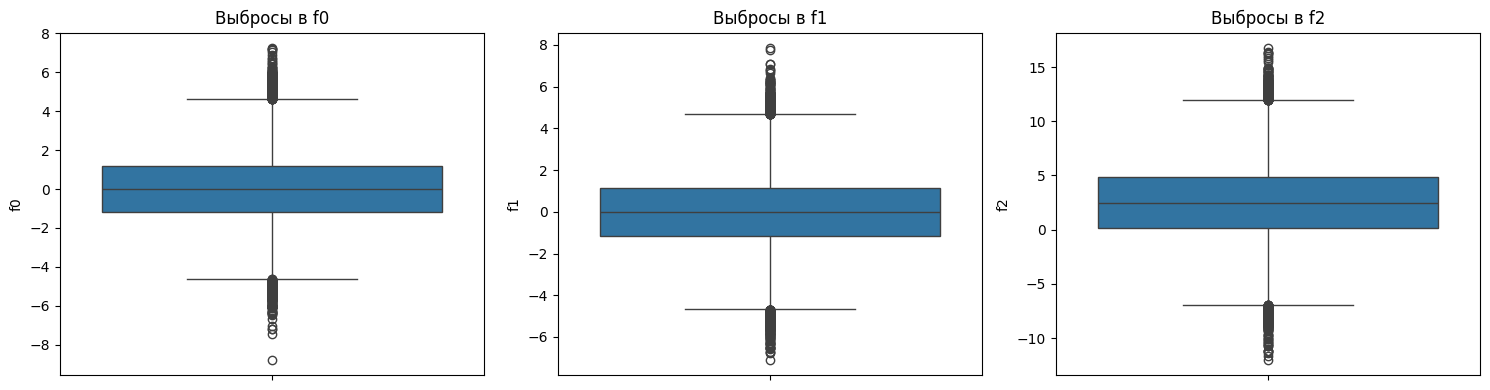

- Выполняю удаление выбросов


Проверка датафрейма geo_data_2_df


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


,f0,f1,f2,product
count,98000.00,98000.00,98000.00,98000.00
mean,0.00,-0.00,2.49,94.78
std,1.68,1.68,3.39,44.68
min,-4.64,-4.68,-6.94,0.00
25%,-1.15,-1.16,0.15,59.33
50%,0.01,-0.01,2.48,94.70
75%,1.15,1.15,4.84,130.32
max,4.64,4.67,11.95,190.03


In [15]:
def run_preprocessor(df_dict=df_dict):
    """Производит предобработку всех датафреймов в цикле в пайплайне"""
    for name, df in df_dict.items():
        print('=' * 50)
        print(f' =>  Обработка датафрейма {name}')
        print('=' * 50)
        df_dict[name] = EDA_Preprocessor_pipeline.fit_transform(df, name)
        globals()[name] = df_dict[name]  # Перезаписывает глобальную переменную
        print(f'\nПроверка датафрейма {name}')
        display(df_dict[name].head())
        display(df_dict[name].describe().round(2))

run_preprocessor(df_dict)

**Промежуточный вывод**

* Были выявлены и удалены неявные неполные дубликаты (id скважины тот же, замеры разные) - были оставлен первый вариант замеров
* Были удалены выбросы по методу IQR
* По признаку f2 во втором регионе (geo_data_1) были обнаружены дискретные значения, хотя ожидались непрерырвные значения. Вероятно были ограничения у оборудования при проведении замеров. Требуется уточнения  и разъяснение ситуации у заказчика. Никаких действий на этот счет не принято.

### **1.5. EDA: Оценка распределения признаков**

Совместим выборки на совмещенном графике посмотрим распределение признаков.

Для непрерывных признаков (f0, f1, f2, product):

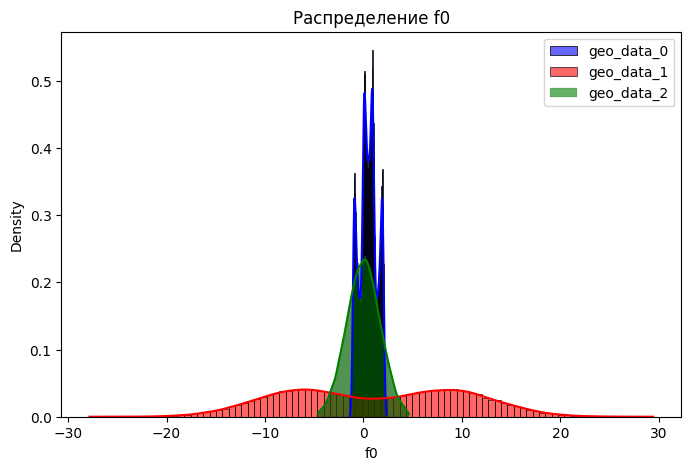

In [16]:
# Непрерывные признаки - нормированные гистограммы
plt.figure(figsize=(8, 5))

sns.histplot(geo_data_0_df['f0'], stat='density', 
             kde=True, alpha=0.6, label='geo_data_0', color='blue')
sns.histplot(geo_data_1_df['f0'], stat='density',
             kde=True, alpha=0.6, label='geo_data_1', color='red')
sns.histplot(geo_data_2_df['f0'], stat='density',
             kde=True, alpha=0.6, label='geo_data_2', color='green')
plt.title('Распределение f0')
plt.xlabel('f0')
plt.ylabel('Density')
plt.legend()
plt.show()

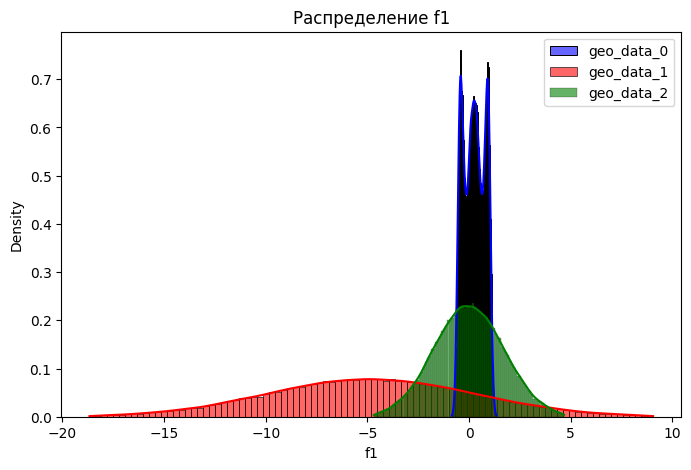

In [17]:
# Непрерывные признаки - нормированные гистограммы
plt.figure(figsize=(8, 5))

sns.histplot(geo_data_0_df['f1'], stat='density', 
             kde=True, alpha=0.6, label='geo_data_0', color='blue')
sns.histplot(geo_data_1_df['f1'], stat='density',
             kde=True, alpha=0.6, label='geo_data_1', color='red')
sns.histplot(geo_data_2_df['f1'], stat='density',
             kde=True, alpha=0.6, label='geo_data_2', color='green')
plt.title('Распределение f1')
plt.xlabel('f1')
plt.ylabel('Density')
plt.legend()
plt.show()

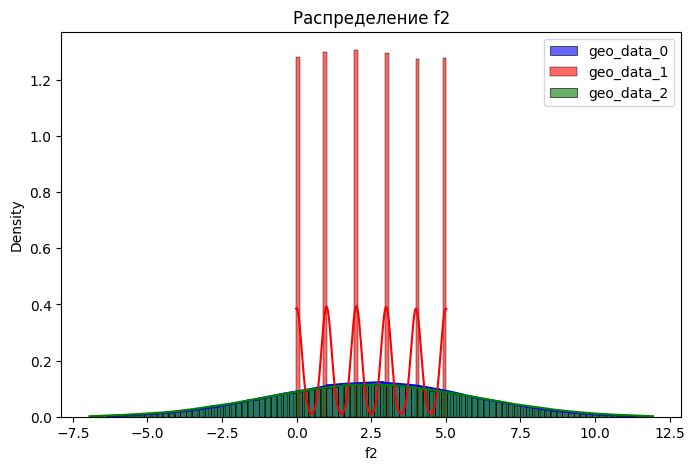

In [18]:
plt.figure(figsize=(8, 5))

sns.histplot(geo_data_0_df['f2'], stat='density', 
             kde=True, alpha=0.6, label='geo_data_0', color='blue')
sns.histplot(geo_data_1_df['f2'], stat='density',
             kde=True, alpha=0.6, label='geo_data_1', color='red')
sns.histplot(geo_data_2_df['f2'], stat='density',
             kde=True, alpha=0.6, label='geo_data_2', color='green')
plt.title('Распределение f2')
plt.xlabel('f2')
plt.ylabel('Density')
plt.legend()
plt.show()

На данных графиках хорошо видны различия в разных регионах по данным признакам.

Так, изучив распределения, можно увидеть, что во втором регионе (geo_data_1) lискретность распределения признака f2 видна на одном из графиков (красные вертикальные линии). Уже на данном этапе можно предположить что что-то не так с измерительным оборудованием во втором регионе: при разведке скважин у оборудования были определенные ограничения, которые и дали дискретные значения. Природа всех признаков должна быть непрерывной, а мы видим дискретность и один из признаков имеет очень сильную линейную корреляцию с целевой переменной, можно говорить об утечке данных в целевую переменную, что может давать иллюзию слишком хороших предсказаний для этого региона. 



Посмотрим на pairplot. (что-то долго он строит график)

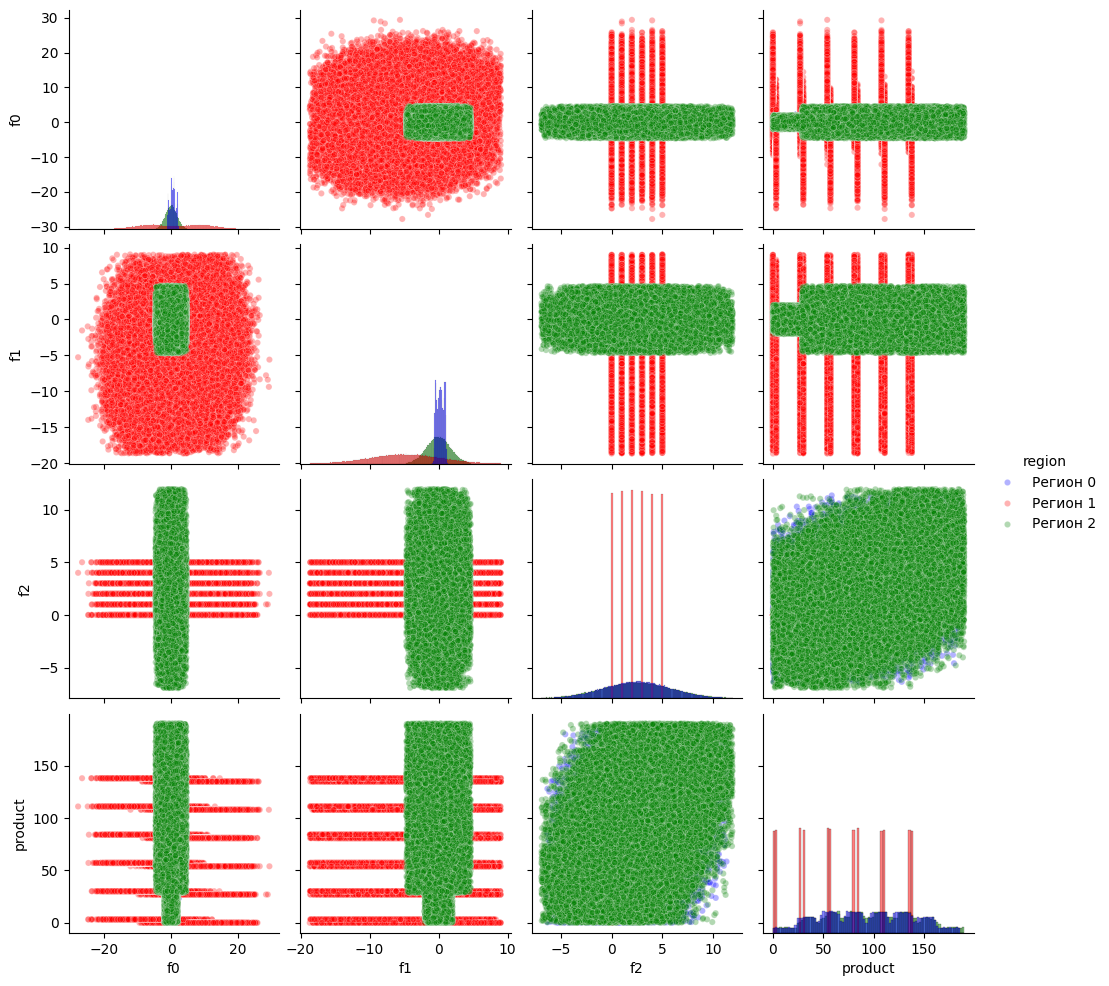

In [19]:
# Объединяем все датасеты с меткой региона
combined_df = pd.concat([
    geo_data_0_df.assign(region='Регион 0'),
    geo_data_1_df.assign(region='Регион 1'), 
    geo_data_2_df.assign(region='Регион 2')
])

# Pairplot с разделением по регионам
sns.pairplot(combined_df[['f0', 'f1', 'f2', 'product', 'region']], 
             hue='region', 
             diag_kind='hist', 
             palette=['blue', 'red', 'green'],
             plot_kws={'alpha': 0.3, 's': 20})
plt.show()

### **1.6. EDA: Корреляционный анализ признаков**
Посмотрим на корреляционный анализ признаков.

Корреляционный анализ признаков в датафрейме GEO_DATA_0_DF


,f0,f1,f2,product
f0,1.00,0.76,0.01,0.21
f1,0.76,1.00,0.00,0.25
f2,0.01,0.00,1.00,0.48
product,0.21,0.25,0.48,1.00


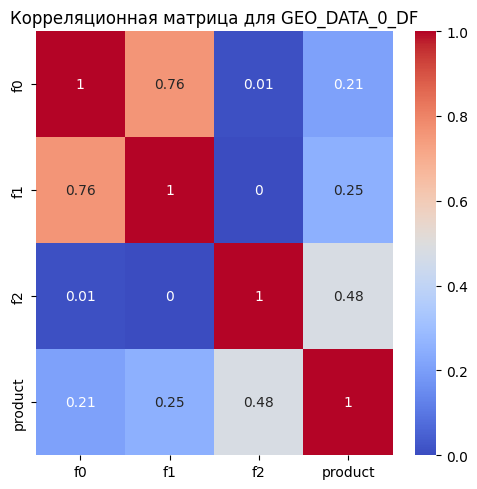

Корреляционный анализ признаков в датафрейме GEO_DATA_1_DF


,f0,f1,f2,product
f0,1.00,0.20,0.02,0.63
f1,0.20,1.00,0.00,0.19
f2,0.02,0.00,1.00,0.98
product,0.63,0.19,0.98,1.00


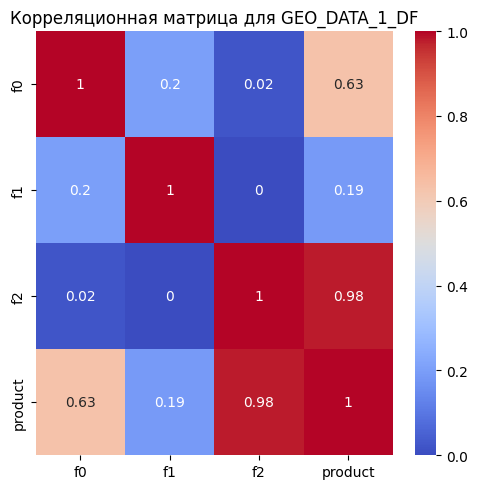

Корреляционный анализ признаков в датафрейме GEO_DATA_2_DF


,f0,f1,f2,product
f0,1.00,0.00,0.00,0.24
f1,0.00,1.00,0.00,0.23
f2,0.00,0.00,1.00,0.44
product,0.24,0.23,0.44,1.00


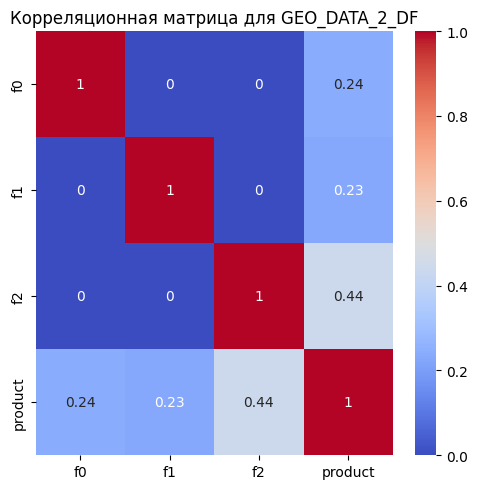

In [20]:
interval_cols = [ # только дробные числа, или которые не в силах посчитать руками и может иметь друбную часть
       'f0', 'f1', 'f2', 'product',
       ]

for name, df in df_dict.items():
    print(f'Корреляционный анализ признаков в датафрейме {name.upper()}')
    phik_corr = df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols).round(2)
    display(phik_corr)

    plt.figure(figsize=(5, 5))
    sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
    plt.title(f'Корреляционная матрица для {name.upper()}')
    plt.tight_layout()
    plt.show()
    
    print('=' * 50)
   

### **1.6.1. EDA: Интерпретация взаимосвязи факторов.**

Мультиколлинеарность не обнаружена, признаки удалять не надо.

Ноибольшая корреляция с целевым признаком product выявлена у признака f2:
* в регионе 0 - product с признаком f2 - 0.48
* в регионе 1 - product с признаком f2 - 0.98
* в регионе 2 - product с признаком f2 - 0.44

Признак f2 наиболее явно сигнализирует о наибольших запасах нефти.

### **1.7. EDA: Вопрос удаления id**

Мы решили пока не удалять id, потому что нам надо будет выбрать прибыльные скважины, значит у них должны быть идентификационные обозначения. Мы id просто не будем включать в выборки, но в исходных датасетах они останутся.

In [21]:
# geo_data_0_df = geo_data_0_df.drop('id', axis=1)
# geo_data_1_df = geo_data_1_df.drop('id', axis=1)
# geo_data_2_df = geo_data_2_df.drop('id', axis=1)

### **1.8. EDA: Проверка наличия дубликатов без id**

In [22]:
for name, df in df_dict.items():
    print(name, df.drop('id', axis=1).duplicated().sum()) # проверка на пропуски

geo_data_0_df 0
geo_data_1_df 0
geo_data_2_df 0


После удаления id дубликатов не появилось.

### **1.9. EDA: Исследовательский анализ.**

Нам необходимо определеить фактические значения в каком регионе наибольшие запасы нефти на основе двухсот наиболее богатых месторождений, а также соответсвенно потенциальную прибыль.

In [23]:
# Bootstrap для каждой валидационной выборки
bootstrap_results = []
results_list = []

for i, (name, df) in enumerate(df_dict.items()):
    region_volume = []
    
    for _ in range(1000):
        # Выбрать 500 случайных наблюдений
        sample_500 = df.sample(n=500, replace=True)

        # Выбрать 200 наиболее богатых
        top_200 = sample_500.nlargest(200, 'product')

        # Суммарная прибыль
        total_volume = top_200['product'].sum()
        region_volume.append(total_volume)
    
    bootstrap_results.append(region_volume)

        # Добавляем данные в список
    results_list.append({
        'Регион': i,
        'Средний запас сырья': np.mean(region_volume),
        'Валовая выручка': np.mean(region_volume) * 450000
    })

    print(f"Регион {i}: средний объем запасов = {np.mean(region_volume):,.2f} тыс. баррелей. Валовая выручка {np.mean(region_volume) * 450000:,.2f} руб.")

# Создаем DataFrame из списка
mean_results_df = pd.DataFrame(results_list)
print("\nИтоговая таблица:")
display(mean_results_df.style.format({  # потому что display игнорирует настройки pandas
    'Средний запас сырья': '{:,.2f}',
    'Валовая выручка': '{:,.2f}'
}))

Регион 0: средний объем запасов = 27,518.98 тыс. баррелей. Валовая выручка 12,383,542,426.13 руб.
Регион 1: средний объем запасов = 23,205.61 тыс. баррелей. Валовая выручка 10,442,523,484.06 руб.
Регион 2: средний объем запасов = 27,987.08 тыс. баррелей. Валовая выручка 12,594,184,109.88 руб.

Итоговая таблица:


,Регион,Средний запас сырья,Валовая выручка
0,0,"27,518.98","12,383,542,426.13"
1,1,"23,205.61","10,442,523,484.06"
2,2,"27,987.08","12,594,184,109.88"


Мы определелии фактически значения на основе представленных данных.

Наибольший объем запасов наблюдается во втором регионе - 28 027 130 баррелей, потенциальная валовая выручка 12,6 млрд руб. 

# **2. Обучение модели**

Из каждого региона есть данные по 100_000 скважин.

Разделим данные  на обучающую и валидационную выборки в соотношении 75:25.

в валидационной выборке останется 25_000 наблюдений. 

Далее 1000 раз делаем имитацию разведки скважин (bootstrap), каждый раз случайным образом отбираются 500 скважин из 25_000, которые в валидационной выборке (т.к. бюджет предполагает возможность разведки только 500 скважин), откуда далее будут выбираться 200 самых прибыльных по прогнозам модели (т.е. где больше всего будет спрогнозирован запас сырья).  
Т.е. в итоге отбираются 200 лучших скважин не из всех 25_000 валидационной выборки, а из случайно отобранных 500 скважин, и так на каждой итерации bootstrap.

После чего обучим модель предсказывать запасы сырья для каждого региона на основе представленных данных и определим средний запас предсказанного сырья.

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

### **2.1. Средний запас предсказанного сырья**

По условию нужно выбирать 200 лучших скважин по предсказаниям модели, а не по фактическим значениям product.

In [24]:
scaler = StandardScaler()
regions = {}
validation_data = {}  # Для сохранения валидационных данных


for i, (name, df) in enumerate(df_dict.items()):

    # 2.1. Разделение данных 75:25
    train_df, valid_df = train_test_split(df, test_size=0.25, random_state=42)
    
    X_train = train_df.drop(['product', 'id'], axis=1)
    y_train = train_df['product']

    X_valid = valid_df.drop(['product', 'id'], axis=1)
    y_valid = valid_df['product']

    # Масштабирование
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    # 2.2. Обучение модели и предсказания
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    rmse = root_mean_squared_error(y_valid, y_pred)
    
    # 2.3. Сохранение предсказаний и правильных ответов
    validation_data[i] = {
        'y_true': y_valid.values,
        'y_pred': y_pred,
        'valid_df': valid_df.copy()
    }
    
    # Добавляем предсказания в валидационный датафрейм
    validation_data[i]['valid_df']['product_pred'] = y_pred

    valid_df_with_pred = valid_df.copy()
    valid_df_with_pred['product_pred'] = y_pred
    
    # Bootstrap с предсказаниями модели
    region_volume = []
    for _ in range(1000):
        # 500 случайных скважин
        sample_500 = valid_df_with_pred.sample(n=500, replace=True)

        # выбираем 200 наиболее богатых по предсказаниям
        top_200 = sample_500.nlargest(200, 'product_pred')

        # Сумма 200 наиболее богатых предсказанных
        total_profit = top_200['product_pred'].sum()
        region_volume.append(total_profit)
    
    regions[i] = {
        'region': model, 
        'y_pred': y_pred,
        'rmse': rmse,
        'bootstrap_profits': region_volume
    }
    
    mean_results_df.loc[mean_results_df['Регион'] == i, 'Средний запас предсказанного сырья'] = np.mean(region_volume)
    mean_results_df.loc[mean_results_df['Регион'] == i, 'RMSE'] = rmse
    mean_results_df.loc[mean_results_df['Регион'] == i, 'Валовая выручка предсказанная'] = np.mean(region_volume) * 450000

    print(f"Регион {i}: Предсказанный средний объем запасов = {np.mean(region_volume):,.2f} тыс. баррелей.  RMSE = {rmse:.2f}. Выручка пресказанная {np.mean(region_volume) * 450000:,.2f} руб.")


Регион 0: Предсказанный средний объем запасов = 23,055.34 тыс. баррелей.  RMSE = 37.80. Выручка пресказанная 10,374,903,676.54 руб.
Регион 1: Предсказанный средний объем запасов = 23,292.57 тыс. баррелей.  RMSE = 0.89. Выручка пресказанная 10,481,656,938.72 руб.
Регион 2: Предсказанный средний объем запасов = 22,863.44 тыс. баррелей.  RMSE = 39.87. Выручка пресказанная 10,288,548,419.28 руб.


In [25]:
for region in validation_data:
    display(f"Регион {region}:")
    display(validation_data[region]['valid_df'][['product', 'product_pred']].head())

'Регион 0:'

,product,product_pred
88626,150.59,137.38
39599,125.15,101.28
18731,127.01,114.11
1725,108.68,100.65
46825,63.43,96.10


'Регион 1:'

,product,product_pred
2452,110.99,110.58
8979,110.99,110.66
10991,110.99,110.99
58271,53.91,54.71
82630,80.86,81.21


'Регион 2:'

,product,product_pred
42639,59.36,77.06
92413,43.13,61.29
15322,172.17,107.64
33205,86.82,86.36
24588,134.72,98.96


Представлены предсказания и правильные ответы на валидационной выборке.

### **2.2. Анализ результатов**

В приведенной таблице мы можем сравнить фактический и предсказанный объем сырья в каждом регионе. 

После оценки рисков (RMSE) нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. 

Мы определили, что в Регионе 1 наименьший риск, т.е. наименьшая ошибка предсказанных значений: RMSE = 0.89. 

В этом же регионе определен наибольший потенциал прибыли, так как в Регионе 1 определен наибольший объем запасов нефти 23,2 млн баррелей.


Таким образом расчитаны основные значения для расчета прибыли.

### **2.3. Промежуточные выводы по обучению модели**

 * Мыразбили данные на обучающую и валидационную выборки в соотношении 75:25.
 * Обучили модель и сделали предсказания на валидационной выборке.
 * Сохранили предсказания и правильные ответы на валидационной выборке.
 * Напечатали на экране средний запас предсказанного сырья и RMSE модели.
 * Проанализировали результаты.

## **3. Подготовка к расчету прибыли**

### **3.1. Все ключевые значения для расчётов в отдельных переменных**

In [26]:
# Ключевые значения для расчетов
BUDGET = 10_000_000_000  # 10 млрд руб - бюджет на разработку региона
WELLS_COUNT = 500  # количество скважин для разработки
BEST_WELLS = 200  # количество лучших скважин
REVENUE_PER_BARREL = 450_000  # выручка за баррель в рублях

### **3.2. Достаточный объём сырья для безубыточной разработки**

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

Мы знаем, что: 
* Бюджет на разработку в регионе 10 млрд руб;
* Отобрать необходимо 200 наиболее богатых скважин.

Таким образом, бюджет для разработки одной скважины равняется 50 млн руб.

Формула для расчета бюджета на разработку каждой скважины:

In [27]:
DEVELOPMENT_COST_PER_WELL = BUDGET / WELLS_COUNT  # 50 млн руб бюджет на каждую скважину

При условии, что 1 барель приносит валовую выручку 450 000 руб, то для выхода в безубыточность, в каждом регионе одна скважина должна содрежать сырья не менее 112 000 баррелей (50 000 000 / 450 000 = 111.11 баррелей).

Формула для расчета минимального запаса сырья в каждой скважине:

In [28]:
MIN_VOLUME = DEVELOPMENT_COST_PER_WELL / REVENUE_PER_BARREL

Таким образом, мы определили достаточный объем сырья в скважине для безубыточной разработки - не менее 45 баррелей.

Сравним полученный объём сырья со средним запасов в каждом регионе. 

In [29]:
print("\nИтоговая таблица:")
display(mean_results_df.style.format({  # потому что display игнорирует настройки pandas
    'Средний запас сырья': '{:,.2f}',
    'Валовая выручка': '{:,.2f}',
    'Средний запас предсказанного сырья': '{:,.2f}',
    'Валовая выручка предсказанная': '{:,.2f}',
    'RMSE': '{:.2f}'
}))


Итоговая таблица:


,Регион,Средний запас сырья,Валовая выручка,Средний запас предсказанного сырья,RMSE,Валовая выручка предсказанная
0,0,"27,518.98","12,383,542,426.13","23,055.34",37.80,"10,374,903,676.54"
1,1,"23,205.61","10,442,523,484.06","23,292.57",0.89,"10,481,656,938.72"
2,2,"27,987.08","12,594,184,109.88","22,863.44",39.87,"10,288,548,419.28"


Здесь мы видим, что во регионе 2 располагаются фактически наибольшие запасы сырья = 28 033 бар.

Но при прогнозировании запасов в данном регионе ошибка расчетов RMSE может достигать 39,87.

В связи с чем, при прогнозировании запасов в данном регионе при получается расчетный объем = 23,037.07 бар.

### **3.3. Промежуточный вывод по этапу подготовки расчета прибыли**

* Все ключевые значения для расчётов сохранили в отдельных переменных.
* Рассчитали достаточный объём сырья для безубыточной разработки новой скважины. 
* Сравнили полученный объём сырья со средним запасом в каждом регионе. 

# **4. Расчет прибыли**

На данном этапе нам необходимо:

 Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

 4.1. Выбрать скважины с максимальными значениями предсказаний. (вероятно, 200 шт.)

 4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.

 4.3. Рассчитать прибыль для полученного объёма сырья.

**Функция для расчета прибыли**

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [30]:
def calculate_profit(total_volume, revenue_revenue_per_barrel, development_cost_per_well):
    """Функция для расчета прибыли, возвращает одно число с прибылью"""
    profit = total_volume * revenue_revenue_per_barrel - development_cost_per_well
    return profit

In [31]:
for region in range(3):
    
    # 4.1. Выбираем 200 лучших по предсказаниям
    top_200_df = validation_data[region]['valid_df'].nlargest(200, 'product_pred')

    # 4.2. Суммируем целевое значение объема сырья
    total_volume = top_200_df['product'].sum()
    
    # 4.3. Рассчитываем прибыль для суммированного объема сырья
    profit = calculate_profit(total_volume, REVENUE_PER_BARREL, DEVELOPMENT_COST_PER_WELL)

    display(f"Регион {region}:")
    display(f"- Cуммарный объем запасов сырья c 200-т крупнейших скважин: {total_volume:,.2f} баррелей")
    display(f"- Потенциальная прибыль с запасов на 200 скважинах: {profit:,.2f} руб.")

'Регион 0:'

'- Cуммарный объем запасов сырья c 200-т крупнейших скважин: 28,852.70 баррелей'

'- Потенциальная прибыль с запасов на 200 скважинах: 12,963,714,502.96 руб.'

'Регион 1:'

'- Cуммарный объем запасов сырья c 200-т крупнейших скважин: 27,589.08 баррелей'

'- Потенциальная прибыль с запасов на 200 скважинах: 12,395,086,696.68 руб.'

'Регион 2:'

'- Cуммарный объем запасов сырья c 200-т крупнейших скважин: 27,860.92 баррелей'

'- Потенциальная прибыль с запасов на 200 скважинах: 12,517,415,164.37 руб.'

Каким образом была рассчитана прибыль: 

* Бюджет на разработку 200 скважин в регионе — 10 млрд рублей, а значит 50 млн на каждую скважину (эти расходы вычитаются из выручки с каждой скважины при расчете прибыли).
* При нынешних ценах один баррель сырья приносит 450 000 рублей дохода. (в та)

# **5. Риски и прибыль для каждого региона**

5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;

5.2. Найдем среднюю прибыль, 95%-й доверительный интервал, определим риск убытков;

In [32]:
# Bootstrap анализ для каждого региона
for region in range(3):
    profits = []
    valid_df = validation_data[region]['valid_df']
    
    # 1000 Bootstrap выборок
    for _ in range(1000):
        sample_500 = valid_df.sample(n=500, replace=True)
        top_200 = sample_500.nlargest(200, 'product_pred')
        total_profit = top_200['product'].sum() * 450_000 - 200 * 50_000_000
        profits.append(total_profit)
    
    # Статистики
    mean_profit = np.mean(profits)
    ci_lower, ci_upper = np.percentile(profits, [2.5, 97.5])
    risk_loss = (np.array(profits) < 0).mean() * 100
    
    print(f"Регион {region}:")
    print(f"  Средняя прибыль: {mean_profit:,.0f} руб")
    print(f"  95% ДИ: [{ci_lower:,.0f}, {ci_upper:,.0f}]")
    print(f"  Риск убытков: {risk_loss:.1f}%\n")

Регион 0:
  Средняя прибыль: 384,902,302 руб
  95% ДИ: [-140,395,752, 894,914,889]
  Риск убытков: 7.2%

Регион 1:
  Средняя прибыль: 474,143,951 руб
  95% ДИ: [74,374,801, 875,819,651]
  Риск убытков: 1.4%

Регион 2:
  Средняя прибыль: 373,025,543 руб
  95% ДИ: [-110,593,039, 914,465,081]
  Риск убытков: 7.3%



# **6. Выводы**

На основании произведенных расчетов мы предлагаем Регион 1 для добычи нефти.

* **Cуммарный объем запасов** сырья c 200-т крупнейших скважин: 27,589.08 баррелей

* **Потенциальная прибыль** с запасов на 200 скважинах: 12,395,086,696.68 руб.

*  **Средняя прибыль:** 469,872,751 руб

  * **95% ДИ:** [71,715,758, 888,676,356]

  * **Риск убытков:** 1.3%